# 01 — Exploratory Data Analysis
## Fitness Workout Recommender

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
print('Libraries loaded!')

Libraries loaded!


In [2]:
df = pd.read_csv('../data/raw/Workout.csv')
print(f'Dataset shape: {df.shape}')
print(f'Columns: {list(df.columns)}')
df.head(10)

Dataset shape: (52, 5)
Columns: ['Body Part', 'Type of Muscle', 'Workout', 'Sets', 'Reps per Set']


,Body Part,Type of Muscle,Workout,Sets,Reps per Set
0,Chest,Upper Chest,Incline dumbbell press,3-4,8-12
1,Chest,Upper Chest,Incline cable crossovers,3-4,10-15
2,Chest,Upper Chest,Incline dumbbell flyes,3-4,10-15
3,Chest,Lower Chest,Decline dumbbell press,3-4,8-12
4,Chest,Lower Chest,Decline cable crossovers,3-4,10-15
5,Chest,Lower Chest,Decline dumbbell flyes,3-4,10-15
6,Chest,Chest Isolation,Chest flyes,3-4,10-15
7,Chest,Chest Isolation,Cable crossovers,3-4,10-15
8,Chest,Chest Isolation,Dumbbell flyes,3-4,10-15
9,Back,Upper,Pull-ups,3-4,8-12


In [3]:
print('--- Data Types ---')
print(df.dtypes)
print()
print('--- Missing Values ---')
print(df.isnull().sum())
print()
print('--- Unique Values ---')
for col in df.columns:
    print(f'{col}: {df[col].nunique()} unique')

--- Data Types ---
Body Part         object
Type of Muscle    object
Workout           object
Sets              object
Reps per Set      object
dtype: object

--- Missing Values ---
Body Part         0
Type of Muscle    0
Workout           0
Sets              0
Reps per Set      0
dtype: int64

--- Unique Values ---
Body Part: 7 unique
Type of Muscle: 18 unique
Workout: 52 unique
Sets: 6 unique
Reps per Set: 7 unique


In [4]:
print('--- Body Parts ---')
print(df['Body Part'].unique())
print()
print('--- Muscle Types ---')
print(df['Type of Muscle'].unique())
print()
print('--- Sets ---')
print(df['Sets'].unique())
print()
print('--- Reps ---')
print(df['Reps per Set'].unique())

--- Body Parts ---
['Chest' 'Back' 'Arms' 'Legs' 'Shoulders' 'Abs' 'Forearms']

--- Muscle Types ---
['Upper Chest' 'Lower Chest' 'Chest Isolation' 'Upper' 'Lower' 'Biceps'
 'Triceps' 'Quadriceps' 'Hamstrings' 'Glutes' 'Calves' 'Anterior'
 'Lateral' 'Posterior' 'Middle' 'Wrist Flexors' 'Wrist Extensors'
 'Grip Strength']

--- Sets ---
['3-4' '3 sets of 10-15 reps per side' '3-5'
 '3 sets of 10-15 reps per leg' '3 sets of 15-20 reps' '30-60 seconds']

--- Reps ---
['8-12' '10-15' '10-16' '8-13' '15-20' '15-21' '1']


## 2. Clean & Standardize

In [5]:
df.columns = ['body_part', 'muscle_type', 'exercise_name', 'sets', 'reps_per_set']

for col in ['body_part', 'muscle_type', 'exercise_name']:
    df[col] = df[col].str.strip().str.lower()

def parse_range(val):
    val = str(val).strip()
    if 'sets' in val.lower():
        nums = [int(s) for s in val.split() if s.isdigit()]
        if nums:
            return nums[0], nums[0]
    if '-' in val:
        parts = val.split('-')
        try:
            return int(parts[0]), int(parts[1])
        except ValueError:
            return None, None
    try:
        n = int(val)
        return n, n
    except ValueError:
        return None, None

df['sets_min'] = df['sets'].apply(lambda x: parse_range(x)[0])
df['sets_max'] = df['sets'].apply(lambda x: parse_range(x)[1])
df['reps_min'] = df['reps_per_set'].apply(lambda x: parse_range(x)[0])
df['reps_max'] = df['reps_per_set'].apply(lambda x: parse_range(x)[1])

df[['exercise_name', 'sets', 'sets_min', 'sets_max', 'reps_per_set', 'reps_min', 'reps_max']].head(10)

,exercise_name,sets,sets_min,sets_max,reps_per_set,reps_min,reps_max
0,incline dumbbell press,3-4,3.0,4.0,8-12,8,12
1,incline cable crossovers,3-4,3.0,4.0,10-15,10,15
2,incline dumbbell flyes,3-4,3.0,4.0,10-15,10,15
3,decline dumbbell press,3-4,3.0,4.0,8-12,8,12
4,decline cable crossovers,3-4,3.0,4.0,10-15,10,15
5,decline dumbbell flyes,3-4,3.0,4.0,10-15,10,15
6,chest flyes,3-4,3.0,4.0,10-15,10,15
7,cable crossovers,3-4,3.0,4.0,10-15,10,15
8,dumbbell flyes,3-4,3.0,4.0,10-15,10,15
9,pull-ups,3-4,3.0,4.0,8-12,8,12


## 3. Feature Engineering

In [6]:
def infer_equipment(name):
    name = name.lower()
    if any(kw in name for kw in ['barbell', 'bench press', 'deadlift']):
        return 'barbell'
    elif any(kw in name for kw in ['dumbbell', 'db']):
        return 'dumbbells'
    elif any(kw in name for kw in ['cable', 'machine', 'lat pulldown', 'leg press', 'seated']):
        return 'machine'
    elif any(kw in name for kw in ['pull-up', 'chin-up', 'dip']):
        return 'pull-up bar'
    elif any(kw in name for kw in ['band', 'resistance']):
        return 'resistance band'
    elif any(kw in name for kw in ['plank', 'crunch', 'push-up', 'lunge', 'bird dog', 'hyperextension', 'calf raise', 'squat', 'leg raise', 'mountain climber']):
        return 'bodyweight'
    else:
        return 'other'

df['equipment'] = df['exercise_name'].apply(infer_equipment)
print('Equipment distribution:')
print(df['equipment'].value_counts())

Equipment distribution:
equipment
other          20
dumbbells       9
bodyweight      8
machine         6
barbell         6
pull-up bar     3
Name: count, dtype: int64


In [7]:
compound_keywords = ['press', 'row', 'pull-up', 'chin-up', 'deadlift', 'squat', 'lunge', 'dip', 'clean', 'snatch']

def classify_movement_type(name):
    if any(kw in name.lower() for kw in compound_keywords):
        return 'compound'
    return 'isolation'

df['movement_type'] = df['exercise_name'].apply(classify_movement_type)
print('Movement type:')
print(df['movement_type'].value_counts())

Movement type:
movement_type
isolation    38
compound     14
Name: count, dtype: int64


In [8]:
def classify_movement_pattern(row):
    name = row['exercise_name'].lower()
    body = row['body_part'].lower()
    if body == 'chest' or ('press' in name and body != 'back'):
        return 'push'
    elif body == 'back' or 'pull' in name or 'row' in name:
        return 'pull'
    elif body == 'legs' and any(kw in name for kw in ['squat', 'lunge', 'leg press', 'leg extension']):
        return 'squat'
    elif body == 'legs' and any(kw in name for kw in ['deadlift', 'hamstring', 'curl']):
        return 'hinge'
    elif body == 'core' or any(kw in name for kw in ['plank', 'crunch', 'ab', 'oblique']):
        return 'core'
    elif body == 'shoulders':
        return 'push'
    elif body == 'arms':
        if 'curl' in name:
            return 'pull'
        elif any(kw in name for kw in ['extension', 'dip', 'pushdown']):
            return 'push'
    return 'other'

df['movement_pattern'] = df.apply(classify_movement_pattern, axis=1)
print('Movement patterns:')
print(df['movement_pattern'].value_counts())

Movement patterns:
movement_pattern
push     18
pull     14
other    13
core      3
squat     2
hinge     2
Name: count, dtype: int64


In [9]:
def estimate_difficulty(row):
    score = 0
    if row['movement_type'] == 'compound':
        score += 1
    if row['equipment'] == 'barbell':
        score += 1
    elif row['equipment'] == 'bodyweight':
        if any(kw in row['exercise_name'] for kw in ['pull-up', 'chin-up', 'dip']):
            score += 1
    if row['reps_max'] and row['reps_max'] <= 10:
        score += 1
    if score >= 2:
        return 'advanced'
    elif score == 1:
        return 'intermediate'
    else:
        return 'beginner'

df['difficulty'] = df.apply(estimate_difficulty, axis=1)
print('Difficulty:')
print(df['difficulty'].value_counts())

Difficulty:
difficulty
beginner        35
intermediate    13
advanced         4
Name: count, dtype: int64


In [10]:
def estimate_duration(row):
    sets = row['sets_max'] if row['sets_max'] else 3
    reps = row['reps_max'] if row['reps_max'] else 10
    time_per_set = (reps * 3) / 60
    rest_per_set = 1.25
    return round(sets * (time_per_set + rest_per_set), 1)

df['est_duration_min'] = df.apply(estimate_duration, axis=1)
df['exercise_id'] = range(len(df))

print(f'Final dataset: {df.shape[0]} exercises, {df.shape[1]} columns')
df.head()

Final dataset: 52 exercises, 15 columns


,body_part,muscle_type,exercise_name,sets,reps_per_set,sets_min,sets_max,reps_min,reps_max,equipment,movement_type,movement_pattern,difficulty,est_duration_min,exercise_id
0,chest,upper chest,incline dumbbell press,3-4,8-12,3.0,4.0,8,12,dumbbells,compound,push,intermediate,7.4,0
1,chest,upper chest,incline cable crossovers,3-4,10-15,3.0,4.0,10,15,machine,isolation,push,beginner,8.0,1
2,chest,upper chest,incline dumbbell flyes,3-4,10-15,3.0,4.0,10,15,dumbbells,isolation,push,beginner,8.0,2
3,chest,lower chest,decline dumbbell press,3-4,8-12,3.0,4.0,8,12,dumbbells,compound,push,intermediate,7.4,3
4,chest,lower chest,decline cable crossovers,3-4,10-15,3.0,4.0,10,15,machine,isolation,push,beginner,8.0,4


## 4. Visualizations

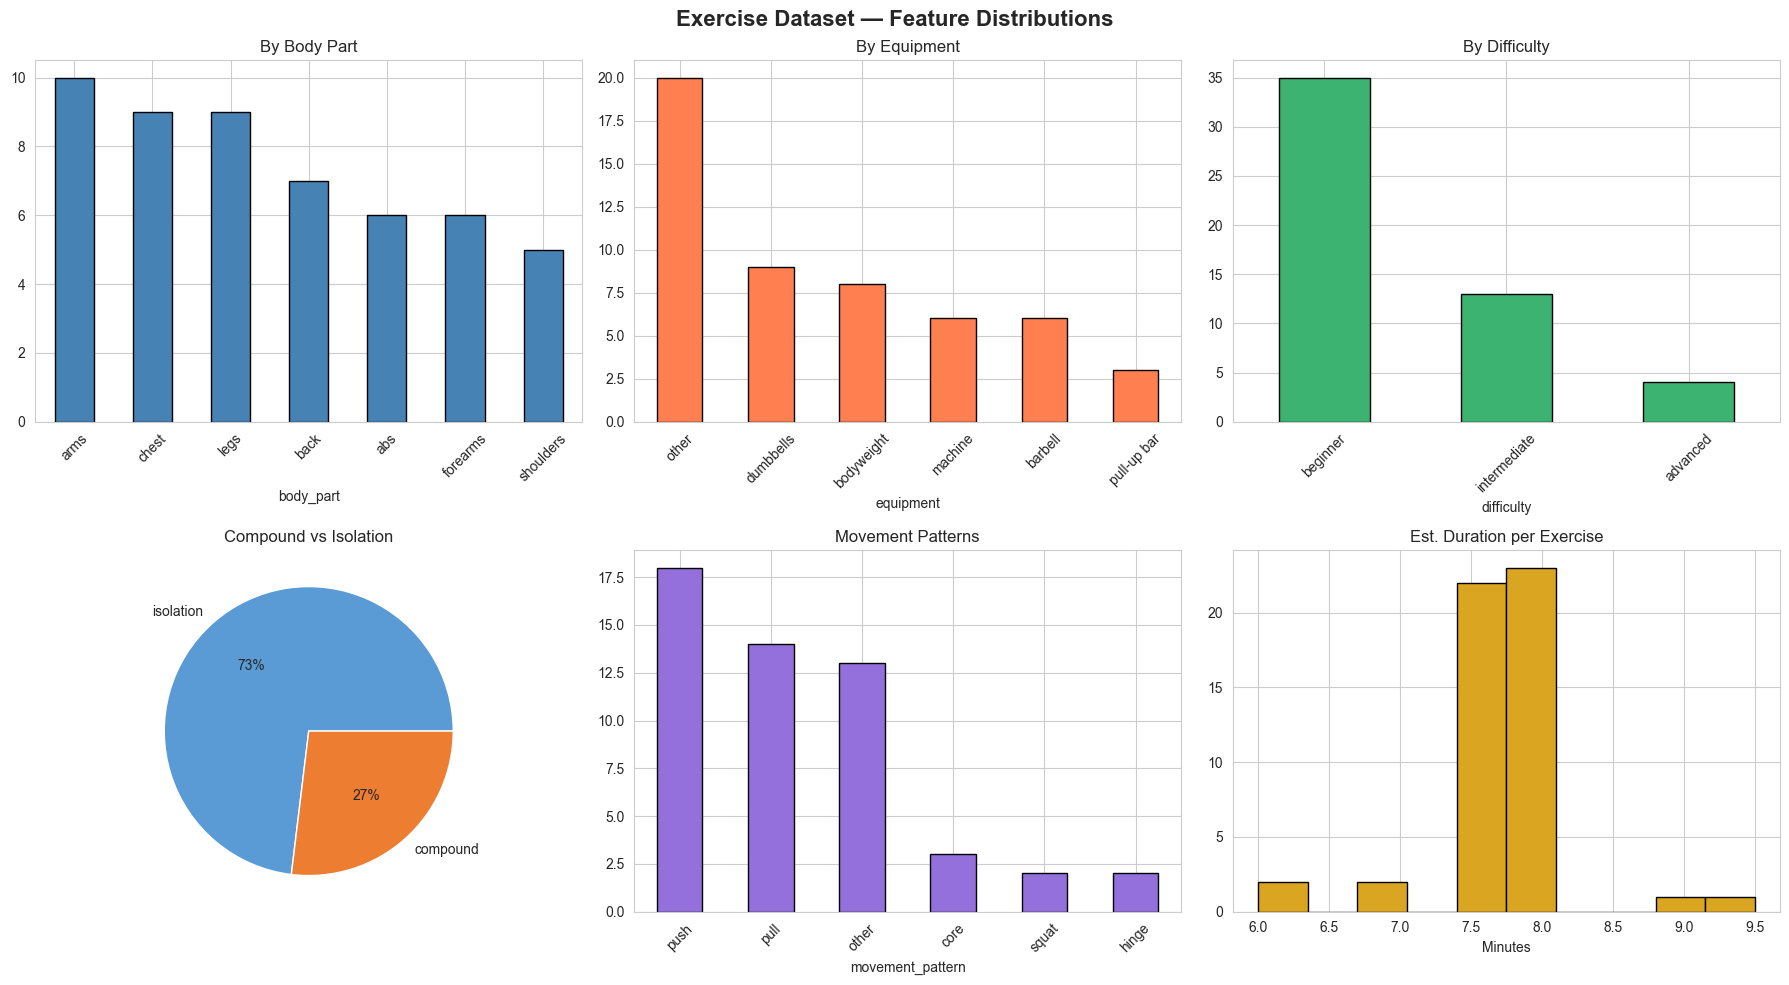

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Exercise Dataset — Feature Distributions', fontsize=16, fontweight='bold')

df['body_part'].value_counts().plot.bar(ax=axes[0,0], color='steelblue', edgecolor='black')
axes[0,0].set_title('By Body Part')
axes[0,0].tick_params(axis='x', rotation=45)

df['equipment'].value_counts().plot.bar(ax=axes[0,1], color='coral', edgecolor='black')
axes[0,1].set_title('By Equipment')
axes[0,1].tick_params(axis='x', rotation=45)

df['difficulty'].value_counts().reindex(['beginner','intermediate','advanced']).plot.bar(ax=axes[0,2], color='mediumseagreen', edgecolor='black')
axes[0,2].set_title('By Difficulty')
axes[0,2].tick_params(axis='x', rotation=45)

df['movement_type'].value_counts().plot.pie(ax=axes[1,0], autopct='%1.0f%%', colors=['#5B9BD5','#ED7D31'])
axes[1,0].set_title('Compound vs Isolation')
axes[1,0].set_ylabel('')

df['movement_pattern'].value_counts().plot.bar(ax=axes[1,1], color='mediumpurple', edgecolor='black')
axes[1,1].set_title('Movement Patterns')
axes[1,1].tick_params(axis='x', rotation=45)

axes[1,2].hist(df['est_duration_min'], bins=10, color='goldenrod', edgecolor='black')
axes[1,2].set_title('Est. Duration per Exercise')
axes[1,2].set_xlabel('Minutes')

plt.tight_layout()
plt.savefig('../results/figures/01_feature_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

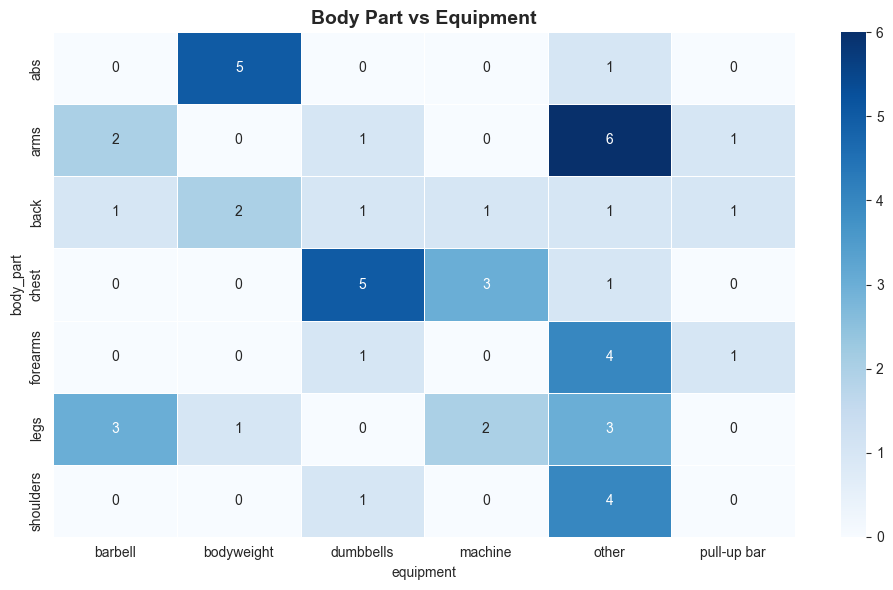

In [12]:
ct = pd.crosstab(df['body_part'], df['equipment'])
plt.figure(figsize=(10, 6))
sns.heatmap(ct, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title('Body Part vs Equipment', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/figures/02_bodypart_equipment_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Export Enriched Dataset

In [14]:
clean_cols = ['exercise_id', 'exercise_name', 'body_part', 'muscle_type', 'equipment',
              'movement_type', 'movement_pattern', 'difficulty', 'sets_min', 'sets_max',
              'reps_min', 'reps_max', 'est_duration_min']
df_clean = df[clean_cols]
df_clean.to_csv('../data/processed/exercises_clean.csv', index=False)
print(f'Exported {len(df_clean)} exercises to data/processed/exercises_clean.csv')
df_clean.head()

Exported 52 exercises to data/processed/exercises_clean.csv


,exercise_id,exercise_name,body_part,muscle_type,equipment,movement_type,movement_pattern,difficulty,sets_min,sets_max,reps_min,reps_max,est_duration_min
0,0,incline dumbbell press,chest,upper chest,dumbbells,compound,push,intermediate,3.0,4.0,8,12,7.4
1,1,incline cable crossovers,chest,upper chest,machine,isolation,push,beginner,3.0,4.0,10,15,8.0
2,2,incline dumbbell flyes,chest,upper chest,dumbbells,isolation,push,beginner,3.0,4.0,10,15,8.0
3,3,decline dumbbell press,chest,lower chest,dumbbells,compound,push,intermediate,3.0,4.0,8,12,7.4
4,4,decline cable crossovers,chest,lower chest,machine,isolation,push,beginner,3.0,4.0,10,15,8.0


## 6. Summary

**Key findings:** (fill in after running!)
- How many exercises per body part?
- Is difficulty balanced?
- Any data quality issues?

**Next:** Notebook 02 — Generate synthetic user profiles and interactions